In [5]:
import pandas as pd
import numpy as np

In [7]:
dataset = pd.read_csv("../datasets/archive_en_p_heur.csv", sep=";")

In [3]:
dataset

,id_device,date,en_L1,cons_en_L1,en_L2,cons_en_L2,en_L3,cons_en_L3,en_L4,cons_en_L4,...,min_THD_L4,max_THD_L4,moy_THD_L4,min_THD_L5,max_THD_L5,moy_THD_L5,min_THD_L6,max_THD_L6,moy_THD_L6,battery_level
0,34,16/07/2019 9:00,8.068350e+02,806.834961,2.069453e+03,2069.452637,1.355756e+02,135.575562,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34,16/07/2019 10:00,2.289109e+03,1482.274170,5.071029e+03,3001.576660,1.358957e+03,1223.381836,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34,16/07/2019 11:00,3.494929e+03,1205.819580,7.951330e+03,2880.300781,2.303930e+03,944.972778,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,16/07/2019 12:00,4.859251e+03,1364.322754,1.078176e+04,2830.430664,3.256703e+03,952.773193,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34,16/07/2019 13:00,6.098753e+03,1239.501465,1.372338e+04,2941.621094,4.057264e+03,800.560791,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74095,253,25/03/2021 2:00,9.906793e+07,5959.625000,9.468990e+07,5776.625000,7.566063e+07,4894.250000,0,0,...,0,0,0,0,0,0,0,0,0,0
74096,253,25/03/2021 3:00,9.907422e+07,6293.125000,9.469575e+07,5852.000000,7.566577e+07,5147.375000,0,0,...,0,0,0,0,0,0,0,0,0,0
74097,253,25/03/2021 4:00,9.908019e+07,5970.000000,9.470129e+07,5531.625000,7.567055e+07,4779.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
74098,253,25/03/2021 5:00,9.908592e+07,5731.625000,9.470688e+07,5597.375000,7.567549e+07,4935.875000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
for k in dataset.keys():
    if len(dataset[k].value_counts()) < 2 :
        dataset.drop(columns=[k], inplace=True)

In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
data = dataset.copy()

In [7]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day_name()
data['hour'] = data['date'].dt.hour

In [8]:
data['cons_glbal'] = data['cons_en_L1'] + data['cons_en_L2'] + data['cons_en_L3'] 

In [9]:
devices = dict(data["id_device"].value_counts())

In [11]:
def transform_data(data, number_of_samples, number_of_result):
    features = data['cons_glbal'].values.reshape(-1,1)
    X, Y = [], []
    list_devices = list(data["id_device"])
    for device in devices :
        start_index = list_devices.index(device)
        for i in range (0,devices[device]-number_of_samples,number_of_samples):
            X.append(features[start_index+i:start_index+i+number_of_samples,0])
            Y.append(features[start_index+i+number_of_samples:start_index+i+number_of_samples+number_of_result,0])

    return X, Y


In [42]:
X, Y = transform_data(data, 50, 1)

In [13]:
X = np.array(X)


In [14]:
Y = np.array(Y)

In [15]:
X.shape

(1481, 50)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
Y = scaler2.fit_transform(Y)

In [17]:
import pickle as pk 

In [18]:
file = open("../models/scaler.pkl", "wb")
pk.dump(scaler, file)
file.close()
file = open("../models/scalerY.pkl", "wb")
pk.dump(scaler2, file)
file.close()

In [19]:
X_scaled = np.expand_dims(X_scaled, -1)

In [20]:
X_scaled.shape

(1481, 50, 1)

In [21]:
Y.shape

(1481, 1)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, shuffle=True)

In [24]:
Y_train

array([[0.0303727 ],
       [0.07204528],
       [0.0945974 ],
       ...,
       [0.16049693],
       [0.19398365],
       [0.08507044]])

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [40]:
model = Sequential()
model.add(LSTM(50, input_shape=(50,1), activation="tanh"))
model.add(Dense(1))
model.compile(loss='MSE', optimizer='adam')
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=100, batch_size=56, verbose=True)

Epoch 1/100
17/17 [==============================] - 7s 117ms/step - loss: 0.0065 - val_loss: 3.7856e-04
Epoch 2/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0025 - val_loss: 1.9389e-04
Epoch 3/100
17/17 [==============================] - 1s 37ms/step - loss: 8.0106e-04 - val_loss: 5.5786e-05
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0017 - val_loss: 5.7546e-05
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0027 - val_loss: 5.2797e-05
Epoch 6/100
17/17 [==============================] - 1s 41ms/step - loss: 8.1802e-04 - val_loss: 5.1834e-05
Epoch 7/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0011 - val_loss: 5.1859e-05
Epoch 8/100
17/17 [==============================] - 1s 47ms/step - loss: 4.1779e-04 - val_loss: 9.1518e-05
Epoch 9/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0012 - val_loss: 5.3340e-05
Epoch 10/100
17/17 [==============================]

17/17 [==============================] - 1s 41ms/step - loss: 0.0016 - val_loss: 6.3761e-05
Epoch 79/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0018 - val_loss: 5.8780e-05
Epoch 80/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0020 - val_loss: 6.3983e-05
Epoch 81/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0011 - val_loss: 6.8308e-05
Epoch 82/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0011 - val_loss: 8.3528e-05
Epoch 83/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0022 - val_loss: 5.7785e-05
Epoch 84/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0013 - val_loss: 6.6195e-05
Epoch 85/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0024 - val_loss: 7.5247e-05
Epoch 86/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0012 - val_loss: 5.7719e-05
Epoch 87/100
17/17 [==============================] - 1s 41ms/step -

In [29]:
model.save("../models/prediction.h5")

In [30]:
from keras.models import load_model

In [31]:
my_loaded_model = load_model("../models/prediction.h5")

In [32]:
my_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [33]:
from keras.utils import plot_model

In [34]:
plot_model(my_loaded_model,
          to_file="../images/model.png",
          show_shapes =True,
           dpi=100
          )

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


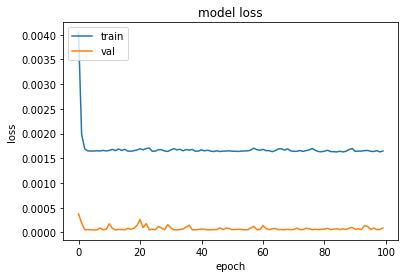

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
trainpred = model.predict(X_train)
valpred = model.predict(X_test)

In [51]:
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform(Y_train)
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform(Y_test])
predictions = valpred

(1184, 1)